# Lecture 18: Robust nonlinear solvers

> Given a continuous function $f(x)$, the problem is to find a point $x^*$ such that $f(x^*) = 0$. That is, $x^*$ is a solution of the equation $f(x) = 0$ and is called a **root of $f(x)$**.

## Summary so far

|                    | Bisection         | Newton's method            | Modified Newton   | Secant            |
|--------------------|-------------------|----------------------------|-------------------|-------------------|
| Simple algorithm   | yes               | yes                        | yes               | yes               |
| Starting values    | bracket           | one                        | one               | two               |
| Iterations         | lots              | normally fewer             | similar to Newton | similar to Newton |
| Function evals     | one per iteration | `f` and `df` per iteration | two per iteration | one per iteration |
| Convergence        | with good bracket | **not always**             | **not always**    | **not always**    |
| Turing point roots | no                | slower                     | slower            | slower            |
| Use of derivative  | no                | yes                        | no                | no                |

## The big idea

Combine the robustness of the bisection but improve the estimate using the secant method.

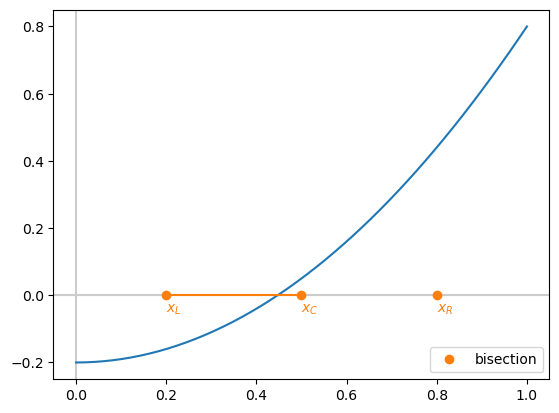

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

plt.axhline(0, color="0.8")  # x = 0
plt.axvline(0, color="0.8")  # y = 0

f = lambda t: t**2 - 0.2
df = lambda t: 2 * t

x = np.linspace(0, 1)
y = f(x)

plt.plot(x, y)

xL = 0.2
xR = 0.8

l = plt.plot([xL, (xL+xR)/2, xR], [0., 0, 0.], 'o', label="bisection")
plt.plot([xL, (xL+xR)/2], [0., 0.], color=l[0].get_color())
plt.text(xL, -0.05, "$x_L$", color=l[0].get_color())
plt.text((xL+xR)/2, -0.05, "$x_C$", color=l[0].get_color())
plt.text(xR, -0.05, "$x_R$", color=l[0].get_color())

plt.legend()
plt.show()

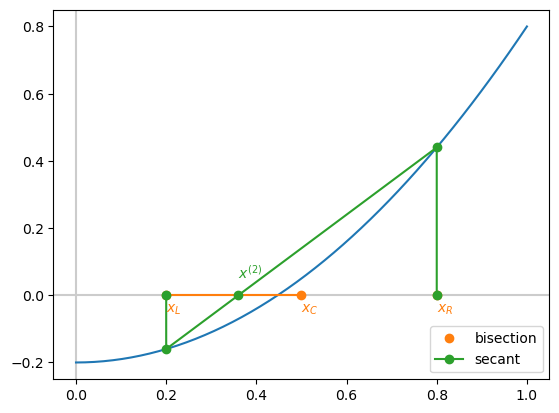

In [2]:
plt.axhline(0, color="0.8")  # x = 0
plt.axvline(0, color="0.8")  # y = 0

f = lambda t: t**2 - 0.2
df = lambda t: 2 * t

x = np.linspace(0, 1)
y = f(x)

plt.plot(x, y)

xL = 0.2
xR = 0.8

l = plt.plot([xL, (xL+xR)/2, xR], [0., 0, 0.], 'o', label="bisection")
plt.plot([xL, (xL+xR)/2], [0., 0.], color=l[0].get_color())
plt.text(xL, -0.05, "$x_L$", color=l[0].get_color())
plt.text((xL+xR)/2, -0.05, "$x_C$", color=l[0].get_color())
plt.text(xR, -0.05, "$x_R$", color=l[0].get_color())

xnew = xR - f(xR) * (xR-xL) / (f(xR) - f(xL))
l = plt.plot([xL, xL, xnew, xR, xR], [0.0, f(xL), 0.0, f(xR), 0], "o-", label="secant")
plt.text(xnew, +0.05, "$x^{(2)}$", color=l[0].get_color())

plt.legend()
plt.show()

The bisection method doesn't use the values of $f$ only it's sign. Use this to improve the convergence rate.

## False position method (regula falisi)

The idea is to take the bisection method but instead of evaluating f and the midpoint of $(x_L, x_R)$ and computing signs, we evaluate at the point obtained from the application of the secant method to $x_L, x_R$:

In [3]:
def false_position(func, a, b, tol=1.0e-10):
    # Starting values
    fa = func(a)
    fb = func(b)
    fc = tol + 1
    
    while b - a > tol and abs(fc) > tol:
        # Find new point **using secant method**
        c = b - fb * (b - a) / (fb - fa)
        fc = func(c)
        
        # if root is in left half of interval
        if fa * fc < 0.0:
            # move right end
            b = c
            fb = fc
        else:
            # otherwise,
            # move the left end
            a = c
            fa = fc
                        
    return c

In [4]:
import pandas as pd

def false_position(func, a, b, tol=1.0e-10):
    # Starting values
    fa = func(a)
    fb = func(b)
    fc = tol + 1
    
    it = 0
    headers = ["it", "a", "f(a)", "b", "f(b)", "c", "f(c)"]
    data = [[it, a, fa, b, fb]]
    
    while b - a > tol and abs(fc) > tol:
        # Find new point **using secant method**
        c = b - fb * (b - a) / (fb - fa)
        fc = func(c)
        
        # if root is in left half of interval
        if fa * fc < 0.0:
            # move right end
            b = c
            fb = fc
        else:
            # otherwise,
            # move the left end
            a = c
            fa = fc
            
        it = it + 1
        data.append([it, a, fa, b, fb, c, fc])
        
    df = pd.DataFrame(data, columns=headers)             
    return df.style.hide_index().set_na_rep("--")

## Example

A simply example $f(x) = x^2 - 2$ starting from bracket $(1, 2)$.

*What happens to the right end of the bracket?*

In [5]:
def f(x):
    return x*x - 2.0

false_position(f, 1.0, 2.0, tol=1.0e-4)

it,a,f(a),b,f(b),c,f(c)
0,1.000000,-1.000000,2.000000,2.000000,--,--
1,1.333333,-0.222222,2.000000,2.000000,1.333333,-0.222222
2,1.400000,-0.040000,2.000000,2.000000,1.400000,-0.040000
3,1.411765,-0.006920,2.000000,2.000000,1.411765,-0.006920
4,1.413793,-0.001189,2.000000,2.000000,1.413793,-0.001189
5,1.414141,-0.000204,2.000000,2.000000,1.414141,-0.000204
6,1.414201,-0.000035,2.000000,2.000000,1.414201,-0.000035


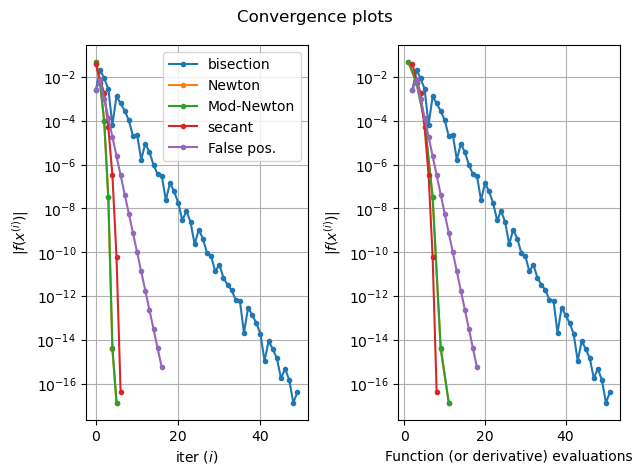

In [6]:
def f(x):
    t = 0.1

    yp = -0.1015 * np.power(x, 4) \
         + 0.2843 * np.power(x, 3) \
         - 0.3516 * np.power(x, 2) \
         - 0.126 * x \
         + 0.2969 * np.sqrt(x)
    f = yp - 0.5 * t

    return f

def df(x):
    dy = -4 * 0.1015 * np.power(x, 3) \
         + 3 * 0.2843 * np.power(x, 2) \
         - 2 * 0.3516 * x \
         - 0.126 \
         + 0.2969 * 0.5 * np.power(x, -0.5)
    f = dy
    
    return f
    
def bisection(func, a, b, tol=1.0e-10):
    # Starting values
    fa = func(a)
    fb = func(b)
    
    feval = [2]
    rets = [(a+b)/2]
    
    while b - a > tol:
        # Find new mid point
        c = (a+b)/2
        fc = func(c)
        
        # if root is in left half of interval
        if fa * fc < 0.0:
            # move right end
            b = c
            fb = fc
        else:
            # otherwise,
            # move the left end
            a = c
            fa = fc
            
        feval.append(feval[-1] + 1)
        rets.append((a+b)/2)
            
    return rets, feval

def newton(f, df, x0, tol=1.0e-10):
    x = x0
    
    feval = [1]
    rets = [x]
        
    while abs(f(x)) > tol:
        x = x - f(x) / df(x)
        rets.append(x)
        feval.append(feval[-1] + 2)
        
    return rets, feval

def modified_newton(f, x0, tol=1.0e-10, maxiter=100):
    eps = np.finfo(np.double).eps
    dx = np.sqrt(eps)
    
    x = x0
    rets = [x]
    feval = [1]
     
    while abs(f(x)) > tol:
        
        df = (f(x + dx) - f(x)) / dx
        x = x - f(x) / df
        
        rets.append(x)
        feval.append(feval[-1] + 2)
    
    return rets, feval
        
def secant(f, x0, x1, tol=1.0e-10):
    # two initial function evaluations
    f0 = f(x0)
    f1 = f(x1)
    
    feval = [2]
    rets = [x1]
    
    while abs(f1) > tol:
        # compute derivative approximation
        df = (f1 - f0) / (x1 - x0)
        # update x
        x2 = x1 - f1 / df
        
        # update other variables
        x0, f0 = x1, f1
        x1, f1 = x2, f(x2) # one evaluation of f per iteration
        
        rets.append(x1)
        feval.append(feval[-1] + 1)
        
    return rets, feval

def false_position(func, a, b, tol=1.0e-10):
    # Starting values
    fa = func(a)
    fb = func(b)
    fc = 2*tol
    
    feval = [2]
    rets = [(a+b)/2]
    
    while b - a > tol and abs(fc) > tol:
        # Find new mid point
        c = b - fb * (b - a) / (fb - fa)
        fc = func(c)
        
        # if root is in left half of interval
        if fa * fc < 0.0:
            # move right end
            b = c
            fb = fc
        else:
            # otherwise,
            # move the left end
            a = c
            fa = fc
            
        feval.append(feval[-1] + 1)
        rets.append(c)
            
    return rets, feval

tol=1.0e-15
bisection_rets, bisection_fevals = bisection(f, 0.5, 1.0, tol=tol)
newton_rets, newton_fevals = newton(f, df, x0=1.0, tol=tol)
modified_rets, modified_fevals = modified_newton(f, x0=1.0, tol=tol)
secant_rets, secant_fevals = secant(f, x0=1.0, x1=0.5, tol=tol)
false_rets, false_fevals = false_position(f, 0.5, 1.0, tol=tol)

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle("Convergence plots")

ax1.semilogy([abs(f(x)) for x in bisection_rets], '.-', label='bisection')
ax1.semilogy([abs(f(x)) for x in newton_rets], '.-',  label='Newton')
ax1.semilogy([abs(f(x)) for x in modified_rets], '.-',  label='Mod-Newton')
ax1.semilogy([abs(f(x)) for x in secant_rets], '.-',  label='secant')
ax1.semilogy([abs(f(x)) for x in false_rets], '.-',  label='False pos.')

ax1.set_xlabel('iter ($i$)')
ax1.set_ylabel('$|f(x^{(i)})|$')
ax1.grid()
ax1.legend()

ax2.semilogy(bisection_fevals, [abs(f(x)) for x in bisection_rets], '.-', label='bisection')
ax2.semilogy(newton_fevals, [abs(f(x)) for x in newton_rets], '.-',  label='Newton')
ax2.semilogy(modified_fevals, [abs(f(x)) for x in modified_rets], '.-',  label='Mod-Newton')
ax2.semilogy(secant_fevals, [abs(f(x)) for x in secant_rets], '.-',  label='secant')
ax2.semilogy(false_fevals, [abs(f(x)) for x in false_rets], '.-',  label='False pos.')

ax2.set_xlabel('Function (or derivative) evaluations')
ax2.set_ylabel('$|f(x^{(i)})|$')
ax2.grid()

plt.tight_layout()
plt.show()

# Dekker's method

This is a another hybrid method that combines the bisection and secant method.

We find two candidates for approximating the root - given by the secant method and by the bisection method. $b$ becomes the new estimate of the root and $a$ is updated to maintain the bracket.

The function requires both an initial bracket *and* an extra guess at the root:

```python
def dekker(func, a, b, bn, tol=1.0e-10): 
    assert func(a) * func(b) < 0 # ensure we have a bracket
    assert abs(b - bn) > tol     # ensure we have b != bn
```

In [7]:
def dekker(func, a, b, bn, tol=1.0e-10):
    while abs(f(b)) > tol:
        # store previous iterate
        bold = b
        
        # generate two possible estimates
        s, m = generate_estimates(func, a, b, bn)
        
        # choose best b
        b = update_b(bn, s, m)
                    
        # choose a to form a bracket
        a = update_a(func, a, b, bn)
       
        # choose best value for iteration from a and b
        a, b = best_ab(func, a, b)
        
        # update old values of b
        bn = bold
    
    return b

In [8]:
def dekker(func, a, b, bn, tol=1.0e-10):
    while abs(f(b)) > tol:
        # store previous iterate
        bold = b
        # generate two possible estimates
        s, m = generate_estimates(func, a, b, bn)
        # choose best b
        b = update_b(bn, s, m)
        # choose a to form a bracket
        a = update_a(func, a, b, bn)
        # choose best value for iteration from a and b
        a, b = best_ab(func, a, b)
        # update old values of b
        bn = bold
    
    return b

In [9]:
def generate_estimates(func, a, b, bn):
    # estimate from secant method on b
    df = (func(b) - func(bn)) / (b - bn)
    s = b - func(b) / df
    
    # estimate from midpoint method
    m = (a + b)/2
    
    return s, m

In [10]:
def dekker(func, a, b, bn, tol=1.0e-10):
    while abs(f(b)) > tol:
        # store previous iterate
        bold = b
        # generate two possible estimates
        s, m = generate_estimates(func, a, b, bn)
        # choose best b
        b = update_b(bn, s, m)
        # choose a to form a bracket
        a = update_a(func, a, b, bn)
        # choose best value for iteration from a and b
        a, b = best_ab(func, a, b)
        # update old values of b
        bn = bold
    
    return b

In [11]:
def update_b(bn, s, m):
    # if s lies between m and bn   
    if (m < s and s < bn) or (bn < s and s < m):
        # b <- s
        return s
    else:
        # b <- m
        return m

In [12]:
def dekker(func, a, b, bn, tol=1.0e-10):
    while abs(f(b)) > tol:
        # store previous iterate
        bold = b
        # generate two possible estimates
        s, m = generate_estimates(func, a, b, bn)
        # choose best b
        b = update_b(bn, s, m)
        # choose a to form a bracket
        a = update_a(func, a, b, bn)
        # choose best value for iteration from a and b
        a, b = best_ab(func, a, b)
        # update old values of b
        bn = bold
    
    return b

In [13]:
def update_a(func, a, b, bn):
    # set a to be either a or b so that f(a)*f(b) < 0   
    if func(a) * func(b) < 0:
        # (a, b) form a bracket: a <- a
        return a
    elif func(bn) * func(b) < 0:
        # (bn, b) form a bracket: a <- bn
        return b
    else:
        raise Exception("No bracket found")

In [14]:
def dekker(func, a, b, bn, tol=1.0e-10):
    while abs(f(b)) > tol:
        # store previous iterate
        bold = b
        # generate two possible estimates
        s, m = generate_estimates(func, a, b, bn)
        # choose best b
        b = update_b(bn, s, m)
        # choose a to form a bracket
        a = update_a(func, a, b, bn)
        # choose best value for iteration from a and b
        a, b = best_ab(func, a, b)
        # update old values of b
        bn = bold
    
    return b

In [15]:
def best_ab(func, a, b):
    # if a is better estimate
    if abs(func(a)) < abs(func(b)):
        # swap!
        return b, a
    else:
        # don't swap!
        return a, b

## Examples

A simply example $f(x) = x^2 - 2$ starting from bracket $(1, 2)$ and `bn`$=2.1$

*What happens to the left end of the bracket?*

In [16]:
def dekker(func, a, b, bn, tol=1.0e-10):
    it = 0
    
    headers = ["it", "a", "f(a)", "b", "f(b)"]
    data = [[it, a, func(a), b, func(b)]]
    
    while abs(f(b)) > tol:
        it += 1
        
        # store previous iterate
        bold = b
        
        # generate two possible estimates
        s, m = generate_estimates(func, a, b, bn)
        
        # choose best b
        b = update_b(bn, s, m)
                    
        # choose a to form a bracket
        a = update_a(func, a, b, bn)
       
        # choose best value for iteration from a and b
        a, b = best_ab(func, a, b)
        
        # update old values of b
        bn = bold
        
        data.append([it, a, func(a), b, func(b)])
        
    df = pd.DataFrame(data, columns=headers)             
    return df.style.hide_index()

In [17]:
def f(x):
    return x*x - 2.0

dekker(f, a=1.0, b=2.0, bn=2.1, tol=1.0e-4)

it,a,f(a),b,f(b)
0,1.000000,-1.000000,2.000000,2.000000
1,1.000000,-1.000000,1.512195,0.286734
2,1.000000,-1.000000,1.430556,0.046489
3,1.000000,-1.000000,1.414758,0.001539
4,1.000000,-1.000000,1.414217,0.000009


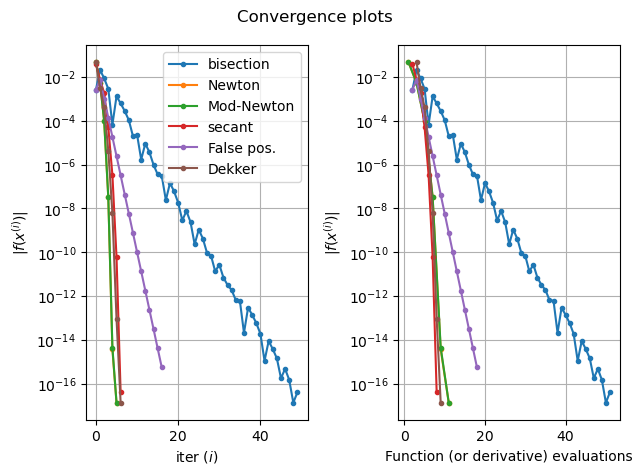

In [19]:
def f(x):
    t = 0.1

    yp = -0.1015 * np.power(x, 4) \
         + 0.2843 * np.power(x, 3) \
         - 0.3516 * np.power(x, 2) \
         - 0.126 * x \
         + 0.2969 * np.sqrt(x)
    f = yp - 0.5 * t

    return f

def df(x):
    dy = -4 * 0.1015 * np.power(x, 3) \
         + 3 * 0.2843 * np.power(x, 2) \
         - 2 * 0.3516 * x \
         - 0.126 \
         + 0.2969 * 0.5 * np.power(x, -0.5)
    f = dy
    
    return f
    
def bisection(func, a, b, tol=1.0e-10):
    # Starting values
    fa = func(a)
    fb = func(b)
    
    feval = [2]
    rets = [(a+b)/2]
    
    while b - a > tol:
        # Find new mid point
        c = (a+b)/2
        fc = func(c)
        
        # if root is in left half of interval
        if fa * fc < 0.0:
            # move right end
            b = c
            fb = fc
        else:
            # otherwise,
            # move the left end
            a = c
            fa = fc
            
        feval.append(feval[-1] + 1)
        rets.append((a+b)/2)
            
    return rets, feval

def newton(f, df, x0, tol=1.0e-10):
    x = x0
    
    feval = [1]
    rets = [x]
        
    while abs(f(x)) > tol:
        x = x - f(x) / df(x)
        rets.append(x)
        feval.append(feval[-1] + 2)
        
    return rets, feval

def modified_newton(f, x0, tol=1.0e-10, maxiter=100):
    eps = np.finfo(np.double).eps
    dx = np.sqrt(eps)
    
    x = x0
    rets = [x]
    feval = [1]
     
    while abs(f(x)) > tol:
        
        df = (f(x + dx) - f(x)) / dx
        x = x - f(x) / df
        
        rets.append(x)
        feval.append(feval[-1] + 2)
    
    return rets, feval
        
def secant(f, x0, x1, tol=1.0e-10):
    # two initial function evaluations
    f0 = f(x0)
    f1 = f(x1)
    
    feval = [2]
    rets = [x1]
    
    while abs(f1) > tol:
        # compute derivative approximation
        df = (f1 - f0) / (x1 - x0)
        # update x
        x2 = x1 - f1 / df
        
        # update other variables
        x0, f0 = x1, f1
        x1, f1 = x2, f(x2) # one evaluation of f per iteration
        
        rets.append(x1)
        feval.append(feval[-1] + 1)
        
    return rets, feval

def false_position(func, a, b, tol=1.0e-10):
    # Starting values
    fa = func(a)
    fb = func(b)
    fc = 2*tol
    
    feval = [2]
    rets = [(a+b)/2]
    
    while b - a > tol and abs(fc) > tol:
        # Find new mid point
        c = b - fb * (b - a) / (fb - fa)
        fc = func(c)
        
        # if root is in left half of interval
        if fa * fc < 0.0:
            # move right end
            b = c
            fb = fc
        else:
            # otherwise,
            # move the left end
            a = c
            fa = fc
            
        feval.append(feval[-1] + 1)
        rets.append(c)
            
    return rets, feval

def dekker(func, a, b, bn, tol=1.0e-10):
    rets = [b]
    fevals = [3]
    
    while abs(f(b)) > tol:
        # store previous iterate
        bold = b
        
        # generate two possible estimates
        s, m = generate_estimates(func, a, b, bn)
        
        # choose best b
        b = update_b(bn, s, m)
                    
        # choose a to form a bracket
        a = update_a(func, a, b, bn)
       
        # choose best value for iteration from a and b
        a, b = best_ab(func, a, b)
        
        # update old values of b
        bn = bold
        
        rets.append(b)
        fevals.append(fevals[-1] + 1)
    
    return rets, fevals

tol=1.0e-15
bisection_rets, bisection_fevals = bisection(f, 0.5, 1.0, tol=tol)
newton_rets, newton_fevals = newton(f, df, x0=1.0, tol=tol)
modified_rets, modified_fevals = modified_newton(f, x0=1.0, tol=tol)
secant_rets, secant_fevals = secant(f, x0=1.0, x1=0.5, tol=tol)
false_rets, false_fevals = false_position(f, 0.5, 1.0, tol=tol)
dekker_rets, dekker_fevals = dekker(f, a=0.5, b=1.0, bn=0.9, tol=tol)

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle("Convergence plots")

ax1.semilogy([abs(f(x)) for x in bisection_rets], '.-', label='bisection')
ax1.semilogy([abs(f(x)) for x in newton_rets], '.-',  label='Newton')
ax1.semilogy([abs(f(x)) for x in modified_rets], '.-',  label='Mod-Newton')
ax1.semilogy([abs(f(x)) for x in secant_rets], '.-',  label='secant')
ax1.semilogy([abs(f(x)) for x in false_rets], '.-',  label='False pos.')
ax1.semilogy([abs(f(x)) for x in dekker_rets], '.-',  label='Dekker')

ax1.set_xlabel('iter ($i$)')
ax1.set_ylabel('$|f(x^{(i)})|$')
ax1.grid()
ax1.legend()

ax2.semilogy(bisection_fevals, [abs(f(x)) for x in bisection_rets], '.-', label='bisection')
ax2.semilogy(newton_fevals, [abs(f(x)) for x in newton_rets], '.-',  label='Newton')
ax2.semilogy(modified_fevals, [abs(f(x)) for x in modified_rets], '.-',  label='Mod-Newton')
ax2.semilogy(secant_fevals, [abs(f(x)) for x in secant_rets], '.-',  label='secant')
ax2.semilogy(false_fevals, [abs(f(x)) for x in false_rets], '.-',  label='False pos.')
ax2.semilogy(dekker_fevals, [abs(f(x)) for x in dekker_rets], '.-',  label='Dekker')

ax2.set_xlabel('Function (or derivative) evaluations')
ax2.set_ylabel('$|f(x^{(i)})|$')
ax2.grid()

plt.tight_layout()
plt.show()

## Summary 

|                    | Bisection         | Newton's method            | Modified Newton   | Secant            | False position    | Dekker            |
|--------------------|-------------------|----------------------------|-------------------|-------------------|-------------------|-------------------|
| Simple algorithm   | yes               | yes                        | yes               | yes               | yes               | more complicated  |
| Starting values    | bracket           | one                        | one               | two               | bracket           | bracket + one     |
| Iterations         | lots              | normally fewer             | similar to Newton | similar to Newton | middle            | similar to Newton |
| Function evals     | one per iteration | `f` and `df` per iteration | two per iteration | one per iteration | one per iteration | one per iteration |
| Convergence        | with good bracket | not always                 | not always        | not always        | with good bracket | with good bracket |
| Turing point roots | no                | slower                     | slower            | slower            | no                | no                |
| Use of derivative  | no                | yes                        | no                | no                | no                | no                |